 ### Predicting Asset Move Direction using Support  Vector Machines  


#### Introduction

This study uses daily closing prices for two "5G-related" stocks from January 2019 to October 2020 and we analyze whether this historical data can help us predict price direction. We treat the problem of stock price forecasting as a binary classification problem and we use Support Vector Machine (SVM) as a learning technique to forecast stock prices direction from past data. The model attempts to predict whether a stock price in the future will be higher or lower than it is on a given day by predicting next day positive or negative move. A selection of suitable kernel functions and features are included before we run the model and we analyze its performance for hard margin and soft margin. We also evaluate the model using ROC, confusion matrix and other metrics. We tackle each task as required by the assignement and we also include along the report our results and
observations related to classification accuracy for each method. We consider this analytical report a small but valuable contribution to the study and the development of prediction models for stock prices.

#### Import libraries
We'll import the required libraries that we will use in this assignement.

In [1]:
# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from mpl_toolkits.mplot3d import Axes3D
import yfinance as yf
import math

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# SVM
from sklearn import svm
from sklearn.svm import SVC, LinearSVC 
from sklearn.calibration import CalibratedClassifierCV
# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

###  Section I:  Support  Vector Machines in-depth 


#### Task # 1: Briefly present the maths of support vectors: hyperplane and margin equations

#### SVM Math Assumptions: hyperplane and margin equations
SVM are binary classifiers that create a decision boundary such that most points in one category fall on one side of the boundary while most points in the other category fall on the other side of the boundary. SVM uses a separating hyperplane in multidimensional space to perform a task. In a $p$ dimensional space, a hyperplane is a flat subspace with p-1 dimensions.

We can define a linear boundary (hyperplane) as

\begin{equation}
\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_p X_p = 0
\end{equation}

  
Then, we can classify the data according to which side of the hyper-plan a data-point lies on.

\begin{eqnarray}
\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_p X_p & > & 0 \\
\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_p X_p & < & 0 \\
\end{eqnarray}

That is, for a test observation  $X$  with  $p$  features we can make predictions by examining the sign of:

\begin{equation}
f(\mathbf{X}) = \beta_0 + \beta_1 X_{1} + \beta_2 X_{2} + \ldots + \beta_p X_{p}
\end{equation}

SVM differs from the other classification algorithms in the way that it chooses the decision boundary that maximizes the distance from the nearest data points of all the classes. An SVM doesn't merely find a decision boundary; it finds the most optimal decision boundary.
 

#### Hard Margin

The optimal hyperplane is such that we maximize the distance from the plane to any point. This is known as the margin and the maximum margin hyperplane best splits the data. The maximum margin classifier is the discriminant function that maximizes the geometric margin $\frac{1}{||w||}$ which is equivalent to minimizing $||w||^2$. This leads to the following constrained optimization problem, where the objective function of the SVM classifier is minimization formulation as follows:


\begin{align}\begin{aligned}\min_ {w, b}  \frac{1}{2} ||w||^{2},\\\begin{split}\textrm {with the constraint } & y_i (w^T X+ b) \geq 1,\\\end{split}\end{aligned}\end{align}

The constraints in this formulation ensure that the maximum margin classifier classifies each example correctly, which is possible since we assumed that the data is linearly separable. 


#### Soft Margin
Not all input features are linearly separable into two classes. The relaxation of the constraint that there be no margin violations will result into the soft-margin classifier. As before, we still look to create the largest possible margin but the model will incur a penalty for vectors that reside in the margin or are on the wrong side of the hyperplane.

To allow errors we replace the inequality constraints in: 

\begin{align}y_i (w^TX+ b) &\geq 1-\zeta_i\end{align}

where $\zeta_i \geq 0$ are slack variables that allow an example to be in the margin $(0 <\zeta_i < 1$, also called
a margin error) or to be misclassified ($\zeta_i > 1$). 

Our
objective of maximizing the margin, i.e. minimizing $\frac{1}{2} ||w||^{2}$ will be augmented with a term $C \sum_i\zeta_i$ to penalize misclassification and margin errors. The degree of violations are controlled by the hyperparameter C and the magnitude of the penalty for each vector is proportional to the slack variable $\zeta_j$.The optimization problem now becomes:


\begin{aligned}\min_ {w, b} \frac{1}{2} ||w||^2 + C \sum_i\zeta_i,\\\begin{split}\textrm {subject to } & y_i (w^T X_i + b) \geq (1 - \zeta_i),\\
& \zeta_j \geq 0. \end{split}\end{aligned}

#### What makes the difference? Softening of the margin by modifying the parameter $𝐶$. 
For the large  $𝐶$ , the margin is hard, and points cannot lie in it. For smaller  $𝐶$ , the margin is softer, and can grow to encompass some points. The small value  $𝐶$   allows the margins to be calculated using more data in the areas close. The large value of  $𝐶$  basically tells our model that we do not have that much faith in our data’s distribution, and will only consider points close or on the line of separation.

#### The worflow

<table>
<thead><tr>
<th style="text-align:left">Steps</th>
<th style="text-align:left">Workflow</th>
<th style="text-align:left">Remarks</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left">Step 1</td>
<td style="text-align:left">Ideation</td>
<td style="text-align:left">Predict the sign of next daily move of Qualcomm (QCOM) and Zoom Video Communications (ZM) stocks</td>
</tr>
<tr>
<td style="text-align:left">Step 2</td>
<td style="text-align:left">Data Collection</td>
<td style="text-align:left">Load QCOM's and ZM's dataset from scikit-learn</td>
</tr>
<tr>
<td style="text-align:left">Step 3</td>
<td style="text-align:left">Exploratory Data Analysis</td>
<td style="text-align:left">Study summary statistics</td>
</tr>
<tr>
<td style="text-align:left">Step 4</td>
<td style="text-align:left">Cleaning Dataset</td>
<td style="text-align:left">Data already cleaned, no further imputation required</td>
</tr>
<tr>
<td style="text-align:left">Step 5</td>
<td style="text-align:left">Transformation</td>
<td style="text-align:left">Perform features scaling</td>
</tr>
<tr>
<td style="text-align:left">Step 6</td>
<td style="text-align:left">Modeling</td>
<td style="text-align:left">Building and training SVM classifier</td>
</tr>
<tr>
<td style="text-align:left">Step 7</td>
<td style="text-align:left">Metrics</td>
<td style="text-align:left">Validating the model performance using score method</td>
</tr>
</tbody>
</table>

#### Step 1 Ideation: the Rise of 5G

#### Task # 2: Make a brief case why your 2 equities are relevant/interesting/easy/difficult to predict with ML techniques.

As we enter an unprecedented era of social distancing, 5G networks are emerging as the most critical infrastructure to meet existing demands. The immediate need to enable more remote work is crucial, but it’s even more critical to deliver high-speed and resilient 5G services for the sake of our public health. As we are experiencing the "Zoom economy" and as we push the limits of existing 4G and broadband infrastructure, it’s imperative that 5G plays a bigger role in order to achieve the low-latency, high bandwidth services that we are all dependent on for remote communications. 

In fact, interest and investable opportunities in 5G-related stocks has accelerated and expanded in the past couple of years because the connectivity benefits of 5G are expected to make businesses more efficient and give consumers access to more information faster than ever before. 

Moreover the industry exposure of 5G-related stocks has become more diversified. While traditionally 5G-related investment opportunities is more commonly found in semiconductors and diversified telecommunications, there is a steady increase in companies coming from wireless telecommunications, technology hardware and the software industry. This is consistent with the industry trend that the wireless Ecosystem is becoming a major application scenario of 5G technology.  

Our stock searching process was to look for companies that are investing into "5G" or "Work from home" theme. Basically, our stock selection was focused on key enablers and beneficiaries in 5G Network Infrastructure, Internet of Things (IoT) Devices and Applications & Services. We found that Qualcomm (QCOM US) has played a major role in inventing the many foundational technologies that drive the industry forward and make up 5G, the next wireless standard. It is a stock with high relevance to 5G and a pure semiconductor play. We have also included Zoom Video Communications (ZM), a provider of video-first communication platform and web conferencing services and the asset can be considered a way to get exposure to the software industry. It offers cloud-based HD video conferencing, mobility, and web meetings and its platform business should get a boost from the large bandwidth of 5G network and current remote working modality adopted by companies all around the world due to COVID-19.

As the 5G theme unfolds, stock picking in the 5G landscape is likely to prove difficult.  By applying machine learning methods to data, investors can gain insights about an investment theme and stocks associated with that theme. We strongly believe that a machine learning approach can capture thematic exposure more accurately, be more timely, and allow for far greater scaling, compared with qualitative stock screens. 

#### Step 2: Data Collection for modeling and testing
The idea is to present the step by step of the whole workflow to be implemented for Qualcomm's stock. We will then repeat the process for Zoom Video Communications's stock and analyse the results of the model's performance for each asset.  

#### Retrieving Data for  Qualcomm (QCOM)
We'll retrieve historical data from yahoo finance using yfinance library

In [2]:
# We load the information from yfinance
# We fetch the data from yahoo using start and end dates
QCOM= yf.download('QCOM', start='2019-01-01' , end='2020-10-23', progress=False)

# Output first five values
QCOM.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,56.200001,58.000000,55.919998,57.400002,54.205219,9896600
2019-01-03,55.950001,56.840000,55.520000,55.700001,52.599842,14422200
2019-01-04,56.500000,56.830002,55.209999,56.599998,53.449738,14177300
2019-01-07,56.389999,57.160000,55.950001,56.439999,53.298649,12352000
2019-01-08,56.709999,56.880001,55.610001,55.950001,52.835922,12110000


In [3]:
# Output first five values
QCOM.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-16,129.699997,130.190002,127.739998,129.029999,129.029999,6625400
2020-10-19,130.130005,131.960007,127.699997,128.419998,128.419998,5765800
2020-10-20,129.179993,129.330002,127.510002,128.300003,128.300003,4409800
2020-10-21,128.039993,130.419998,126.370003,128.550003,128.550003,4344000
2020-10-22,129.509995,129.589996,126.860001,128.380005,128.380005,3895100


In [4]:
# We make sure the index datatype is in a proper date time format
QCOM.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2020-10-09', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22'],
              dtype='datetime64[ns]', name='Date', length=457, freq=None)

#### Visualizing a Price Series
We'll now plot historical price series of Qualcomm's stock price.

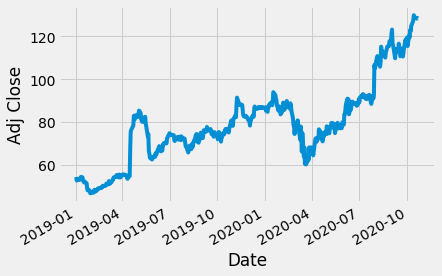

In [5]:
QCOM['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.show()

#### Features Selection

We are going to run SVM calissifer on the following set of features $"Ret_{t-1},Ret_{t-2},Ret_{5D}$,OHL, MOM 1D, MOM 5D, SMA 5D, EMA 7D, STD 21D, Volume", that are used to predict whether or not the stock’s price in the future will be higher (+1) or lower (-1) than the current day’s price, where: 

<table>
<thead><tr>
<th style="text-align:left">Features</th>
<th style="text-align:left">Type</th>
<th style="text-align:left">Remarks</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left">Feature 1</td>
<td style="text-align:left">Ret_i</td>
<td style="text-align:left">return at time i (i is a day, or a month, or a year... it depends of the measure of unit) </td>
</tr>
<tr>    
<td style="text-align:left">Feature 2</td>
<td style="text-align:left">Ret_5D_t,</td>
<td style="text-align:left">realized returns over a period of 5 previous days</td>
</tr>
<tr>
<td style="text-align:left">Feature 3</td>
<td style="text-align:left">MOM 1D </td>
<td style="text-align:left">the momentum of 1 day</td>
</tr>
<tr>
<td style="text-align:left">Feature 4</td>
<td style="text-align:left">MOM 5D </td>
<td style="text-align:left">the momentum of 5 days</td>
</tr>
<tr>
<td style="text-align:left">Feature 5</td>
<td style="text-align:left">SMA 5D</td>
<td style="text-align:left">standard deviation average of 5 days</td>
</tr>
<tr>
<td style="text-align:left">Feature 6</td>
<td style="text-align:left">EMA 7D</td>
<td style="text-align:left">exponential moving average of 7 days </td>
</tr>
<tr>
<td style="text-align:left">Feature 7</td>
<td style="text-align:left">STD 21D</td>
<td style="text-align:left">standard deviation of last 21 days</td>
</tr>
<td style="text-align:left">Feature 8</td>
<td style="text-align:left">Volume</td>
<td style="text-align:left">Volume</td>
<tr>
<td style="text-align:left">Feature 9</td>
<td style="text-align:left">OHL</td>
<td style="text-align:left">Open, High and Low </td>  
</tr>
</tbody>
</table>        

It is however important to note that after having defined a set of features it is instructive to perform feature selection: remove features that do not contribute to the accuracy of the classifier and vice-versa.

In [6]:
price_QCOM = np.round(QCOM['Adj Close'],3)
Open_QCOM = np.round(QCOM['Open'],3)
High_QCOM = np.round(QCOM['High'],3)
Low_QCOM = np.round(QCOM['Low'],3)

# Calculating our returns for our stock QCOM  
rt_QCOM=np.around([math.log(price_QCOM[t]/price_QCOM[t+1]) for t in range(0,len(price_QCOM)-1)],3)
rt_QCOM_t_2=np.around([math.log(price_QCOM[t+1]/price_QCOM[t+2]) for t in range(0,len(price_QCOM)-2)],3)
rt_QCOM_t_5=np.around([math.log(price_QCOM[t+4]/price_QCOM[t+5]) for t in range(0,len(price_QCOM)-5)],3)

rt_5D_t_1=np.around([math.log(price_QCOM[t]/price_QCOM[t+5]) for t in range(0,len(price_QCOM)-5)],3)
rt_10D_t_1=np.around([math.log(price_QCOM[t]/price_QCOM[t+10]) for t in range(0,len(price_QCOM)-10)],3)

MOM1D=np.around([price_QCOM[t]-price_QCOM[t+1] for t in range(0,len(price_QCOM)-1)],3)
MOM5D=np.around([price_QCOM[t]-price_QCOM[t+5] for t in range(5,len(price_QCOM)-5)],3)
SMA5D=np.around(price_QCOM.reindex(index=price_QCOM.index[::-1]).rolling(5).mean(),3).tolist()
SMA5D.reverse()
EMA7D=np.around(price_QCOM.reindex(index=price_QCOM.index[::-1]).ewm(span=7).mean(),3).tolist()
EMA7D.reverse()
STD21D=np.around([np.std(rt_QCOM[t:t+21]) for t in range(0,len(rt_QCOM)-21)],3)

#### Step 3: Exploratory data analysis - Study summary statistics  

A first goal is to construct a data frame that describes the main characteristics of QCOM and ZM, our stocks under study from the 5-G universe. We will start with the construction of the data frame of features for asset QCOM: 

In [7]:
N=len(STD21D)
data_QCOM={#'Date':QCOM['Date'][:N],
'Returns 1D': rt_QCOM[:N].tolist(),
'Returns 2D': rt_QCOM_t_2[:N].tolist(),
'Returns 5D': rt_QCOM_t_5[:N].tolist(),
'Returns 5D, t': rt_5D_t_1[:N].tolist(),
'Returns 10D, t': rt_10D_t_1[:N].tolist(),
'Open':Open_QCOM[:N].tolist(),
'High':High_QCOM[:N].tolist(),
'Low':Low_QCOM[:N].tolist(),
'Mom 1D':MOM1D[:N].tolist(),
'Mom 5D':MOM5D[:N].tolist(),
'SMA 5D':SMA5D[:N],
'EMA 7D':EMA7D[:N],
'STD 21D':STD21D.tolist(),
'Volume': QCOM['Volume'][:N]/1e6}        

In [8]:
X=pd.DataFrame(data_QCOM)
X

,Returns 1D,Returns 2D,Returns 5D,"Returns 5D, t","Returns 10D, t",Open,High,Low,Mom 1D,Mom 5D,SMA 5D,EMA 7D,STD 21D,Volume
Date,,,,,,,,,,,,,,
2019-01-02,0.030,-0.016,-0.012,0.014,0.038,56.20,58.00,55.92,1.605,1.265,53.278,53.298,0.017,9.8966
2019-01-03,-0.016,0.003,-0.003,-0.020,0.017,55.95,56.84,55.52,-0.850,1.917,53.129,52.995,0.016,14.4222
2019-01-04,0.003,0.009,-0.012,-0.016,0.024,56.50,56.83,55.21,0.151,2.106,53.337,53.127,0.016,14.1773
2019-01-07,0.009,-0.012,0.003,-0.015,0.039,56.39,57.16,55.95,0.463,2.843,53.507,53.019,0.016,12.3520
2019-01-08,-0.012,-0.003,0.028,0.004,0.078,56.71,56.88,55.61,-0.623,3.739,53.669,52.926,0.016,12.1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-16,-0.003,0.037,0.029,0.035,-0.027,118.00,118.00,114.54,-0.320,-7.110,113.174,113.844,0.021,6.3401
2020-09-17,0.037,-0.011,-0.015,0.024,-0.040,111.92,115.70,111.00,4.190,-7.330,112.376,113.605,0.021,7.4181
2020-09-18,-0.011,-0.017,-0.020,-0.034,-0.042,115.04,115.43,109.80,-1.230,-0.970,111.838,113.179,0.019,15.4432


Data preprocessing here involves firstly dividing the data into attributes and labels and then,  dividing the data into training and testing sets.

#### Define Label
Here, the target variable is whether QCOM's price will close up or down on the next trading day. 

In [9]:
Y=pd.DataFrame({#'Date':QCOM['Date'][:N],
    'Sign': np.sign(X['Returns 1D'])})

# To keep the continuity of time series, we can re-label 'no moves' as positive moves. We transform zeros 
# into ones which is more approriate as we remain on the binomial scheme. 
for i in range(len(Y['Sign'])):
    if Y['Sign'][i]==0:
        Y['Sign'][i]=1

# We check the output
Y

,Sign
Date,
2019-01-02,1.0
2019-01-03,-1.0
2019-01-04,1.0
2019-01-07,1.0
2019-01-08,-1.0
...,...
2020-09-16,-1.0
2020-09-17,1.0
2020-09-18,-1.0


In [10]:
Y.shape  # Target Label should be 1D

(435, 1)

#### 2D and 3D Scatterplots
Before starting our modelling procedure, we are going to visualize and analyse graphically if we can spot any correlation amongst a variety of features plotted on 2D and 3D scatterplots. 

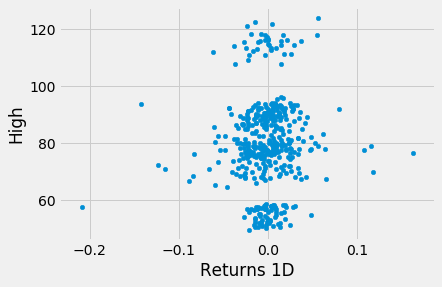

In [11]:
# 2D scatterplots
X.plot(kind='scatter', x='Returns 1D', y='High')
plt.show()

It seems we can identify 3 different clusters from the graph.

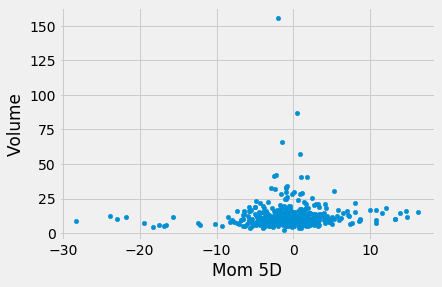

In [12]:
# 2D scatterplots
X.plot(kind='scatter', x='Mom 5D', y='Volume')
plt.show()

It is difficult to identify a correlation pattern between features 'Volume' and 'Mom 5D', but there is a concentration of points around the origin.

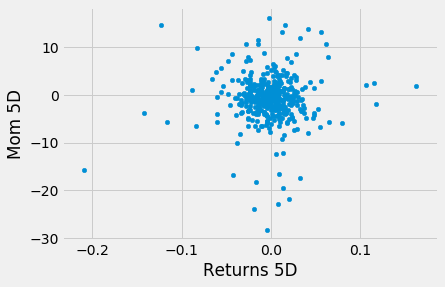

In [13]:
X.plot(kind='scatter', x='Returns 5D', y='Mom 5D')
plt.show()


It is difficult to identify a correlation pattern between features 'Mom 5D' and 'M'

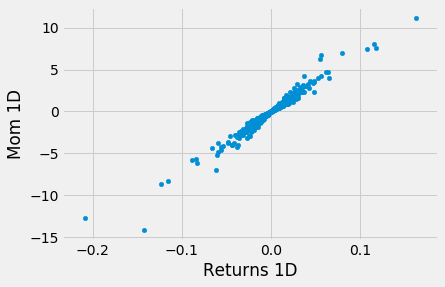

In [14]:
X.plot(kind='scatter', x='Returns 1D', y='Mom 1D')
plt.show()

The graph above shows a significant correlation between features "Mom 1D" and "Returns 1D". (Not suprising!)

We also show some 3D plots just to point out that it could be usuful to compare 3 different features.

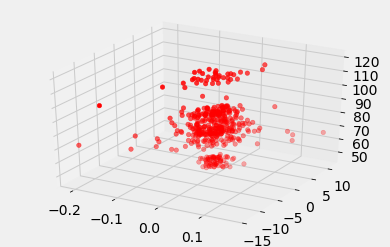

In [15]:
# 3D scatterplots

figure = plt.figure()
ax=figure.add_subplot(111, projection='3d')
ax.scatter(X['Returns 1D'], X['Mom 1D'], X['SMA 5D'], c='r', marker='o')
plt.show()

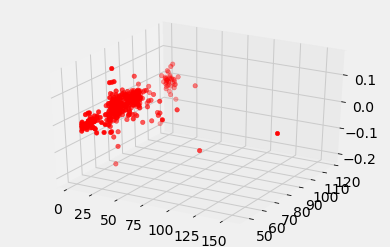

In [16]:
figure = plt.figure()
ax=figure.add_subplot(111, projection='3d')
ax.scatter(X['Volume'], X['EMA 7D'], X['Returns 1D'], c='r', marker='o')
plt.show()

#### Task # 3: Make a decision about the use of StandardScaler and version of SVM

#### Feature Scaling: 
Feature scaling is one of the most critical steps during the pre-processing of data before creating actual machine learning model. The idea of feature scaling is to make sure that features are on a similar scale. Scaling can make a big difference between a weak machine learning model and a better one. The scaling can be accomplished by using the StandardScaler transformer.

#### StandardScaler 
Standardization is the most common (default) scaling method for most machine learning preprocessing. The preprocessing module further provides a utility class StandardScaler that implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set (please refer to sklearn.preprocessing.StandardScaler documentation). The purpose of the pipeline is to assemble several steps than can be cross-validated together while setting different parameters. This class is hence suitable for use in the early steps of a sklearn.pipeline, which we chose to include as part of our preprocessing implementation in this report for both assets.

#### Step 4	Cleaning Dataset: The Data is already cleaned, no further imputation required. 


Once the data is divided into attributes and labels, the final preprocessing step is to divide data into training and test sets. 

#### Split Data 
When doing the training stage of any algorithm we could use all of the data. But that doesn’t tell us how robust the model is. To do this properly, first of all, we divide up the original data or input data into two parts, training and test sets. In previous studies on this topic, the machine learning model has typically been trained on 70% of the dataset and tested on the remaining 30%. We keep similar proportions.

In [17]:
# Splitting the datasets into training and testing data.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 304, 131


The training set contains 304 samples and the test set contains 131 samples. 

#### Task # 4: Present comparisons of hard vs. soft margin cases and draw conclusions on which ‘works better’.


Let's compare hard vs soft margin cases by tuning of the hyperparameter $C$, which can be thought of as a tradeoff between preferring large margin and preferring small number of misclassified data points. A small $C$ prefers large margins but allow potentially large number of misclassified points (ignore errors/underfit the data). A large $C$ prefers small number of misclassified examples at the expense of smaller margin (high tendency to overfit). Further sections down in this report, we show a more efficient way of selecting an optimal value of variable $C$.

Let's try to identify the countours' decision boundary form of the SVM classifier respect of the features 'Returns 1D' and 'EMA 7D'.

In [18]:
X_Features_2D = X_train.loc[:,['Returns 1D', 'EMA 7D']]

C=1e5 #To soften the margins try much smaller values, such as C=1
SVM_2D = SVC(C=C, probability=True) #kernel='linear'
SVM_2D.fit(X_Features_2D, Y_train)

# Plot the decision function for a 2D SVC
def plot_svc_decision_function(model, ax=None, plot_support=True):
	if ax is None:
		ax = plt.gca()
	xlim = ax.get_xlim()
	ylim = ax.get_ylim()
	xlim = (-3, 3) #Correction to see the entire decision boundary for SVM_2D based on X_Features.loc[:,['Returns 1D', 'EMA 7D']]
	
	# create grid to evaluate model
	x = np.linspace(xlim[0], xlim[1], 30)
	y = np.linspace(ylim[0], ylim[1], 30)
	Y, X = np.meshgrid(y, x)
	xy = np.vstack([X.ravel(), Y.ravel()]).T
	P = model.decision_function(xy).reshape(X.shape)	
	
	# plot decision boundary and margins
	ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
	
	# plot support vectors
	if plot_support:
		ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, linewidth=1, facecolors='none');
	ax.set_xlim(xlim)
	ax.set_ylim(ylim)

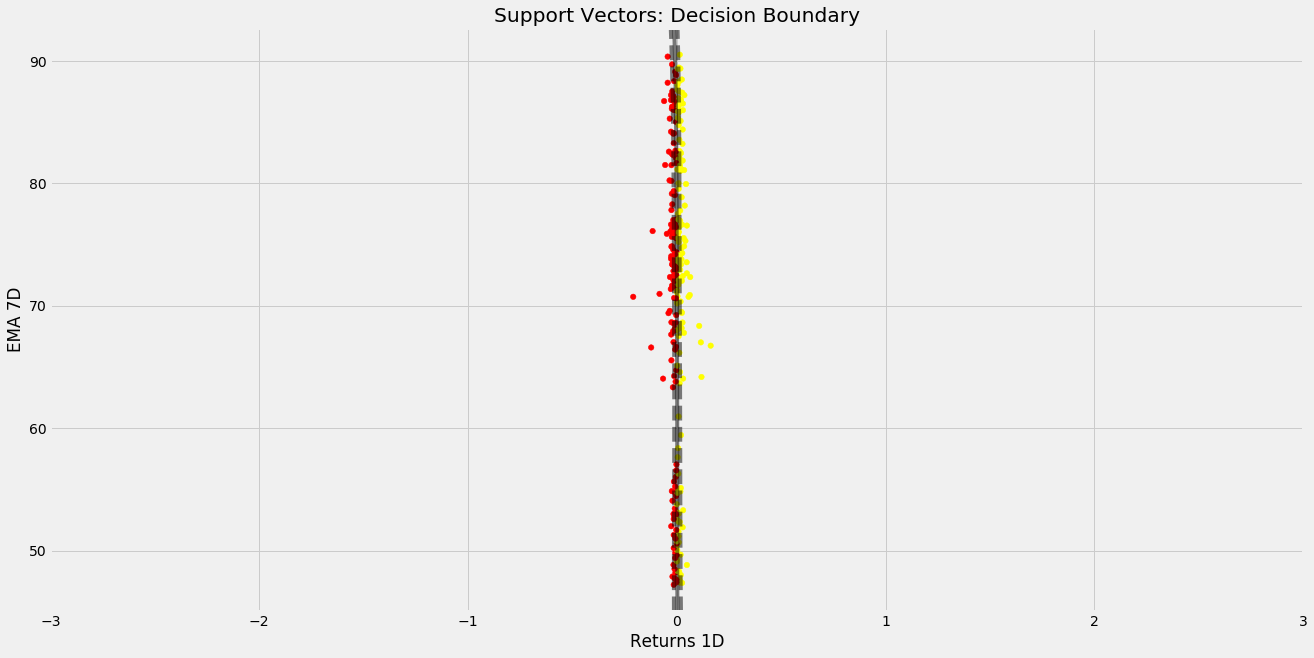

In [19]:
# Below only works with 2D features
plt.clf
plt.figure(figsize=(20, 10)) #facecolor='w'
plt.scatter(X_Features_2D['Returns 1D'], X_Features_2D['EMA 7D'], c=Y_train['Sign'], s=30, cmap='autumn')
plot_svc_decision_function(SVM_2D);
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Returns 1D')
plt.ylabel('EMA 7D')
plt.title('Support Vectors: Decision Boundary')
#plt.legend(loc="lower right")
#plt.savefig('plot_name') #Save into file
plt.show()

We can clearly observe that the decision boundary does a good job at dividing our colored dots from the sample, at least for the chosen features. Moreover, contours of the decision boundary show that here, hyperplane is a line.

Let's inspect 2D plots on models such as SVC with linear kernel, LinearSVC (linear kernel), SVC with RBF kernel and SVC with polynomial (degree 3) kernel to evaluate if it is necesary to vary the kernel type. Our intuition is that varying the kernel type is likely to add complexity without a gain. 

<Figure size 432x288 with 0 Axes>

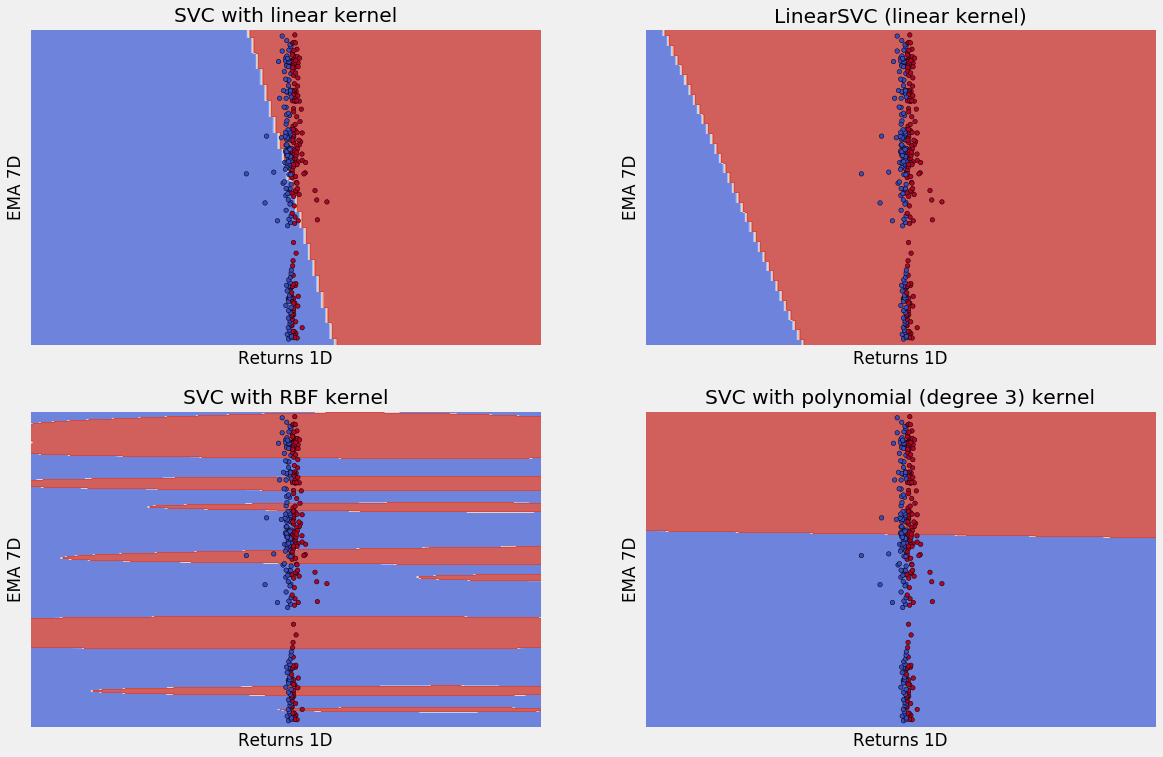

In [20]:
X_Features_2D = X_train.loc[:,['Returns 1D', 'EMA 7D']]
C = 1 # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
svm.LinearSVC(C=C),
svm.SVC(kernel='rbf', gamma=0.7, C=C),
svm.SVC(kernel='poly', degree=3, C=C))
# title for the plots
titles = ('SVC with linear kernel',
'LinearSVC (linear kernel)',
'SVC with RBF kernel',
'SVC with polynomial (degree 3) kernel')

models = (classifier.fit(X_Features_2D, Y_train) for classifier in models)

def make_meshgrid(x, y, h=.02):
	"""Create a mesh of points to plot in
	Parameters
	----------
	x: data to base x-axis meshgrid on
	y: data to base y-axis meshgrid on
	h: stepsize for meshgrid, optional
	Returns
	-------
	xx, yy : ndarray
	"""
	x_min, x_max = x.min() - 1, x.max() + 1
	y_min, y_max = y.min() - 1, y.max() + 1
	xx, yy = np.meshgrid(np.arange(x_min,x_max, h), np.arange(y_min, y_max, h))
	return xx, yy
def plot_contours(ax, clf, xx, yy, **params):
	"""Plot the decision boundaries for a classifier.
	Parameters
	----------
	ax: matplotlib axes object
	clf: a classifier
	xx: meshgrid ndarray
	yy: meshgrid ndarray
	params: dictionary of params to pass to contourf, optional
	"""
	Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
	Z = Z.reshape(xx.shape)
	out = ax.contourf(xx, yy, Z, **params)
	return out

#models = (classifier.fit(X_train, Y_train) for classifier in models)
X0, X1 = X_Features_2D['Returns 1D'], X_Features_2D['EMA 7D']
#X0, X1 = X_train['Returns'], X_train['EMA 7D']
Y0 = Y_train['Sign'].ravel() 
plt.clf()
fig, sub = plt.subplots(2, 2, figsize=(18,12))
#plt.subplots_adjust(wspace=0.4, hspace=0.4)
xx, yy = make_meshgrid(X0, X1)
for clf, title, ax in zip(models, titles, sub.flatten()):
	plot_contours(ax, clf, xx, yy,	cmap=plt.cm.coolwarm, alpha=0.8)
	ax.scatter(X0, X1, c=Y0, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
	ax.set_xlim(xx.min(), xx.max())
	ax.set_ylim(yy.min(), yy.max())
	ax.set_xlabel('Returns 1D')
	ax.set_ylabel('EMA 7D')
	ax.set_xticks(())
	ax.set_yticks(())
	ax.set_title(title)
plt.show()

We aknowledge that our graphs are not the best and we apologize for it. But from the graphs above these lines and the graph about the decision boundary, a first observation suggests that there is no need to vary the type of kernel. In fact, we observe also from the graphs that we should then use the Linear SVC (linear kernel) model as data distribution seems linearly separable. Although we plot just 2 features, this seems to be a linear classification problem, so we will continue to treat the problem as such. We then create an instance of SVM and fit out the data.

#### Task # 5: Provide 2D illustrations (feature vs. dependent variable) with linear hyperplanes – at least four of your choice. SVM also allows to consider feature A vs feature B, but avoid juxtaposing features computed using the same information – such features are colinear and there is no prediction.

Despite that our classifier is going to handle more than 2 features, let's observe 2D plots with linear hyperplanes. It is important to note that it is still not clear for us why it is useful to analyze these plots, because there isn't a clear relationship between the hiperplane in the case $n=2$ and the hiperplane for $n=15$. Maybe the $2-dim$ hiperplane is a projection of the $15-dim$ hiperplane, but we are not convinced and that analysis is beyond the scope of this analytical report. 

<Figure size 432x288 with 0 Axes>

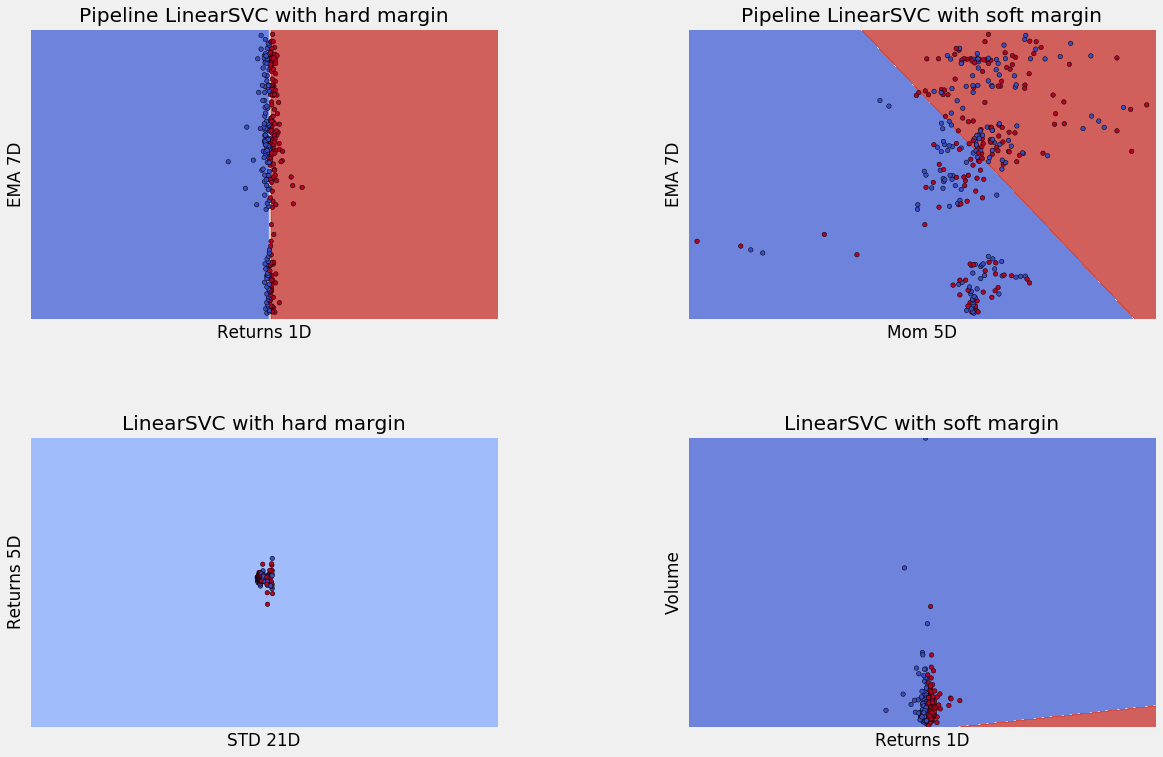

In [21]:
# with pipeline
SVMpipe_hard=Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e5))]).fit(X_train.loc[:,['Returns 1D', 'EMA 7D']],Y_train)
SVMpipe_soft=Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e-5))]).fit(X_train.loc[:,['Mom 5D', 'EMA 7D']],Y_train)
# without pipeline
Xt_train_1 = StandardScaler().fit(X_train.loc[:,['STD 21D','Returns 5D']]).transform(X_train.loc[:,['STD 21D','Returns 5D']])
SVM_manual_hard=LinearSVC(C=1e5).fit(Xt_train_1,Y_train)
Xt_train_2 = StandardScaler().fit(X_train.loc[:,['Returns 1D','Volume']]).transform(X_train.loc[:,['Returns 1D','Volume']])
SVM_manual_soft=LinearSVC(C=1e-5).fit(Xt_train_2,Y_train)
models = (SVMpipe_hard,
          SVMpipe_soft,
          SVM_manual_hard,
          SVM_manual_soft)
#############################################3
X0 = [X_train['Returns 1D'], X_train['EMA 7D']]
X1 = [X_train['Mom 5D'], X_train['EMA 7D']]
X2 = [X_train['STD 21D'], X_train['Returns 5D']]
X3 = [X_train['Returns 1D'], X_train['Volume']]
scatters=(X0,
          X1,
          X2,
          X3)
Y0 = Y_train['Sign'].ravel() 
##################################
titles = ('Pipeline LinearSVC with hard margin',
'Pipeline LinearSVC with soft margin',
          'LinearSVC with hard margin',
'LinearSVC with soft margin')
label_0=['Returns 1D', 'EMA 7D']
label_1=['Mom 5D', 'EMA 7D']
label_2=['STD 21D', 'Returns 5D']
label_3=['Returns 1D','Volume']
labels=(label_0,
        label_1, 
        label_2,
        label_3)
##################################
plt.clf()
fig, sub = plt.subplots(2, 2, figsize=(18,12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for ax, clf, title, label, scatter in zip(sub.flatten(),models, titles, labels, scatters):
        xx, yy = make_meshgrid(scatter[0], scatter[1])
        plot_contours(ax, clf, xx, yy,	cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(scatter[0], scatter[1], c=Y0, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
plt.show()

#### Step 5 & 6  Transformation and Modelling: 

#### Fit Model
We will now create, fit and train the SVM. Remember that we are going to compare the performance of both models:
SVM hard margin and SVM soft margin. 

In [22]:
SVMpipe_hard=Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e5))]).fit(X_train,Y_train)
SVMpipe_soft=Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e-5))]).fit(X_train,Y_train)

#### Step 7 Metrics: Evaluating the model Classifier and Prediction Accuracy

Confusion matrix, precision, recall, and F1 measures are the most commonly used metrics for classification tasks. Scikit-Learn's metrics library contains the classification report, confusion matrix methods and area under ROC curve, which can be readily used to find out the values for these important metrics.

Let's now predict the labels of the test set:

In [23]:
# Predicting the test dataset
Y_pred_hard = SVMpipe_hard.predict(X_test)
Y_pred_hard[-5:]

array([-1.,  1., -1., -1.,  1.])

In [24]:
# Predicting the test dataset
Y_pred_soft = SVMpipe_soft.predict(X_test)
Y_pred_soft[-5:]

array([1., 1., 1., 1., 1.])

Accuracy can be computed by comparing actual test set values and predicted values.

In [25]:
# Model Accuracy: how often is the classifier correct?
# Output prediction score
print(f'Train Accuracy: {SVMpipe_hard.score(X_train,Y_train):0.4}')
print(f'Test Accuracy: {SVMpipe_hard.score(X_test,Y_test):0.4}')

Train Accuracy: 1.0
Test Accuracy: 0.9695


In [26]:
print(f'Train Accuracy: {SVMpipe_soft.score(X_train,Y_train):0.4}')
print(f'Test Accuracy: {SVMpipe_soft.score(X_test,Y_test):0.4}')

Train Accuracy: 0.8158
Test Accuracy: 0.8321


We can see that SVM model hard margin has a better performance than the SVM model soft margin.

#### Classification Report

For further evaluation, a classification report is used to measure the quality of predictions from a classification algorithm where we can also check precision, recall, f1_score and support of our model. Let's take a look at how the classifier is performing.

In [27]:
print(classification_report(Y_test, Y_pred_hard))

              precision    recall  f1-score   support

        -1.0       0.97      0.97      0.97        69
         1.0       0.97      0.97      0.97        62

    accuracy                           0.97       131
   macro avg       0.97      0.97      0.97       131
weighted avg       0.97      0.97      0.97       131



In [28]:
print(classification_report(Y_test, Y_pred_soft))

              precision    recall  f1-score   support

        -1.0       0.98      0.70      0.81        69
         1.0       0.74      0.98      0.85        62

    accuracy                           0.83       131
   macro avg       0.86      0.84      0.83       131
weighted avg       0.87      0.83      0.83       131



Accuracy scores, recall (sensitivity), precision and other similar metrics are subsets of confusion matrix. F1 scores are the harmonic means of precision and recall. Support columns in classification report tell us about the actual counts of each class in test data.
And we can observe that the model with better performance regarding these metrics is the SVM hard margin.

#### Task # 6: Investigate the prediction quality using area under ROC curve (each class) and confusion matrix 

We know that we have to consider the accuracy and pattern of prediction within each class. We use the tools of confusion matrix and area under the ROC curve to investigate.

#### Confusion Matrix:  Allows to look into accuracy of prediction within each class.

A confusion matrix is a table used to describe the performance of a classification model on a set of test data for which the true values are known. Confusion matrix tells us about the distribution of our predicted values across all the actual outcomes. We plot below the confusion matrix of the exercise with our model classifiers: 

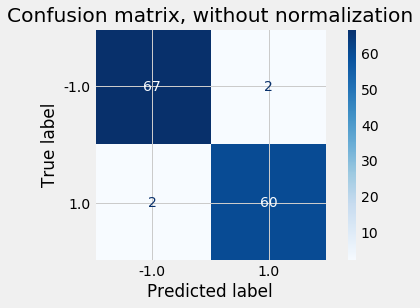

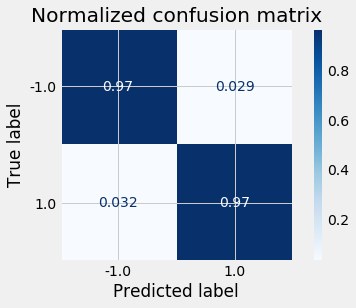

In [29]:
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(SVMpipe_hard, X_test, Y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

We observe that FP and FN (FP= false positive and FN= False negative) in the normalized confusion matrix are almost 0.  


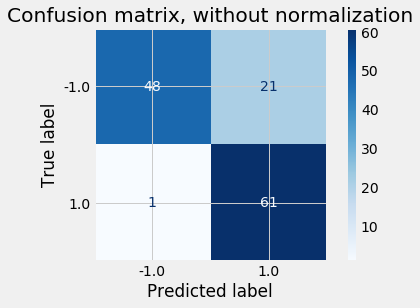

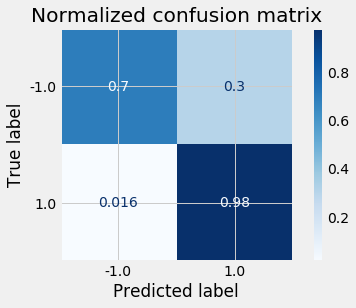

In [30]:
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(SVMpipe_soft, X_test, Y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

We observe that in this case, FP throws a significant error of 30%. 

Again, the SVM hard margin is more accurate than SVM soft margin.


#### Area under ROC Curve

The receiver operating characteristic (ROC) curve is a common metric for the binary classifiers. It tells how a much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. An excellent model has AUC near to the 1 which means it has good measure of separability. A poor model has AUC near to the 0 which means it has worst measure of separability. In fact it means it is reciprocating the result, it is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means model has no class separation capacity whatsoever.

At this stage of the report, we are aware that fitting again each classifier model is computationally and timely expensive, but our intention is to plot and show the ROC curve, beyond its cost in terms of efficiency.

In [31]:
SVMpipe_hard=CalibratedClassifierCV(Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e5))]).fit(X_train,Y_train)).fit(X_train,Y_train)
SVMpipe_hard_total=CalibratedClassifierCV(Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e5))]).fit(X,Y)).fit(X,Y)

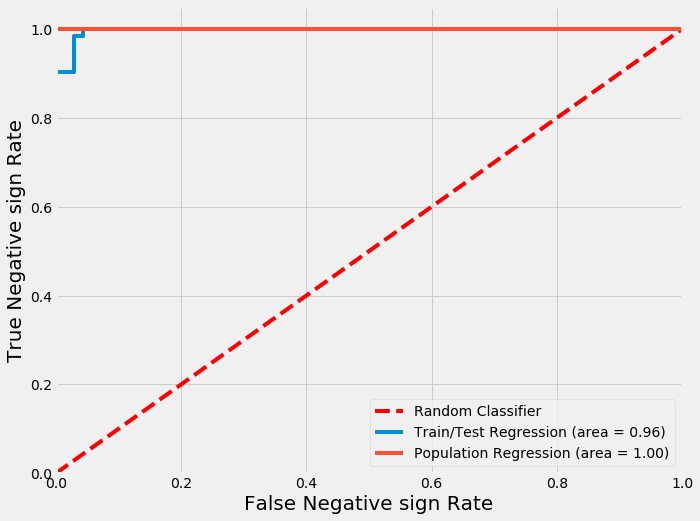

In [32]:
def plot_logistic_ROC(sign_ind):
	sign_name = ['Positive sign', 'Negative sign'] # This is in terms of label for Positives for Roc Curve
	logit_roc_aucT = roc_auc_score(Y_test, SVMpipe_hard.predict(X_test)) #Here, SVM_manual can run on Test or repeated on Train
	fprT, tprT, thresholdsT = roc_curve(Y_test, SVMpipe_hard.predict_proba(X_test)[:,1], pos_label=sign_ind)
	logit_roc_aucP = roc_auc_score(Y, SVMpipe_hard_total.predict(X))
	fprP, tprP, thresholdsP = roc_curve(Y, SVMpipe_hard_total.predict_proba(X)[:,1], pos_label=sign_ind)
	fig, ax = plt.subplots(figsize=(10,8))
	#fig = plt.figure(figsize=(18,10))
	# 1) Plot a diagnoal line of fully random classifier
	ax.plot([0, 1], [0, 1],'r--', label='Random Classifier')
	# 1) Plot ROC Curve for the precictions on Test Dataset
	ax.plot(fprT, tprT, label='Train/Test Regression (area = %0.2f)' % logit_roc_aucT)
	# 1) Plot ROC Curve for the Full Dataset (Population)
	ax.plot(fprP, tprP, label='Population Regression (area = %0.2f)' % logit_roc_aucP)
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False ' + sign_name[sign_ind] + ' Rate', fontsize=20)
	plt.ylabel('True ' + sign_name[sign_ind] + ' Rate', fontsize=20)
	plt.legend(loc="lower right", fontsize=14)
	plt.show()
	return ax
plot_logistic_ROC(1)

In [33]:
SVMpipe_soft=CalibratedClassifierCV(Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e-5))]).fit(X_train,Y_train)).fit(X_train,Y_train)
SVMpipe_soft_total=CalibratedClassifierCV(Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e-5))]).fit(X,Y)).fit(X,Y)

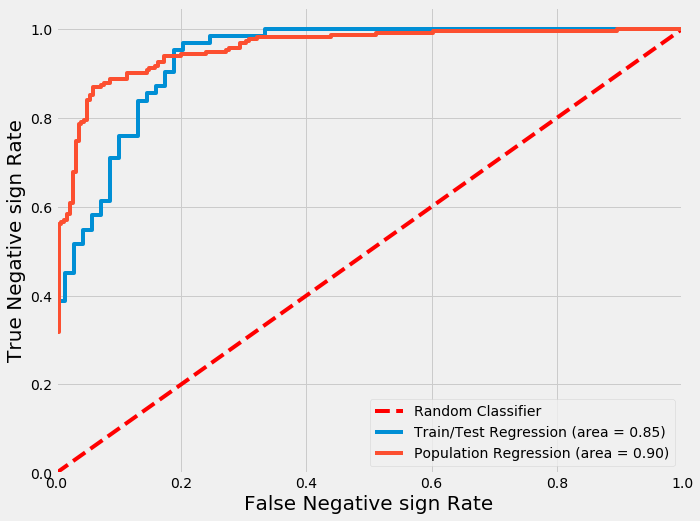

In [34]:
def plot_logistic_ROC(sign_ind):
	sign_name = ['Positive sign', 'Negative sign'] # This is in terms of label for Positives for Roc Curve
	logit_roc_aucT = roc_auc_score(Y_test, SVMpipe_soft.predict(X_test)) #Here, SVM_manual can run on Test or repeated on Train
	fprT, tprT, thresholdsT = roc_curve(Y_test, SVMpipe_soft.predict_proba(X_test)[:,1], pos_label=sign_ind)
	logit_roc_aucP = roc_auc_score(Y, SVMpipe_soft_total.predict(X))
	fprP, tprP, thresholdsP = roc_curve(Y, SVMpipe_soft_total.predict_proba(X)[:,1], pos_label=sign_ind)
	fig, ax = plt.subplots(figsize=(10,8))
	#fig = plt.figure(figsize=(18,10))
	# 1) Plot a diagnoal line of fully random classifier
	ax.plot([0, 1], [0, 1],'r--', label='Random Classifier')
	# 1) Plot ROC Curve for the precictions on Test Dataset
	ax.plot(fprT, tprT, label='Train/Test Regression (area = %0.2f)' % logit_roc_aucT)
	# 1) Plot ROC Curve for the Full Dataset (Population)
	ax.plot(fprP, tprP, label='Population Regression (area = %0.2f)' % logit_roc_aucP)
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False ' + sign_name[sign_ind] + ' Rate', fontsize=20)
	plt.ylabel('True ' + sign_name[sign_ind] + ' Rate', fontsize=20)
	plt.legend(loc="lower right", fontsize=14)
	plt.show()
	return ax
plot_logistic_ROC(1)

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

#### Cross-validation: Gridsearch to determine the value of C

A good way to estimate the better $C$ to be used is to perform a grid search before the final training.
GridSearch performs exhaustive search over specified parameter values for an estimator. It implements a “fit” and a “score” method among other methods. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid. 

In [35]:
SVMpipe = Pipeline([('scale', StandardScaler()), ('SVC',LinearSVC())]) 
param_grid = {'SVC__C':np.arange(1e-5,1e5,100)}
SVMpipe = GridSearchCV(SVMpipe,param_grid,cv=5,return_train_score=True)
SVMpipe.fit(X_train,Y_train)
print(SVMpipe.best_params_)

{'SVC__C': 100.00001}


In [36]:
bestlinearSVC = SVMpipe.best_estimator_
bestlinearSVC.fit(X_train,Y_train)
bestlinearSVC.coef_ = bestlinearSVC.named_steps['SVC'].coef_
bestlinearSVC.score(X_train,Y_train)

0.993421052631579

We can observe that the optimal hyperparameter is $C=100$ 

### II) The following section will present the previous format applied to QCOM, but this time for the stock Zoom Video Communications (ZM).

#### Step 1: Data Collection for modeling and testing

### Retrieving Data for Zoom Video Communications (ZM)
We'll retrieve historical data from yahoo finance using yfinance library

In [37]:
# We load the information from yfinance
# We fetch the data from yahoo using start and end dates
ZM= yf.download('ZM', start='2019-01-01' , end='2020-10-23', progress=False)

# Output first five values
ZM.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-18,65.000000,66.000000,60.320999,62.000000,62.000000,25764700
2019-04-22,61.000000,68.900002,59.939999,65.699997,65.699997,9949700
2019-04-23,66.870003,74.168999,65.550003,69.000000,69.000000,6786500
2019-04-24,71.400002,71.500000,63.160000,63.200001,63.200001,4973500
2019-04-25,64.739998,66.849998,62.599998,65.000000,65.000000,3863300


In [38]:
# Output first five values
ZM.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-16,544.000000,565.450012,543.250000,559.000000,559.000000,13745800
2020-10-19,572.500000,588.840027,562.549988,568.340027,568.340027,15193200
2020-10-20,572.330017,575.690002,534.590027,537.020020,537.020020,12098200
2020-10-21,535.880005,551.659973,511.779999,513.190002,513.190002,9215400
2020-10-22,521.780029,530.429993,503.470001,520.539978,520.539978,8100900


In [39]:
# We make sure the index datatype is in a proper date time format
ZM.index

DatetimeIndex(['2019-04-18', '2019-04-22', '2019-04-23', '2019-04-24',
               '2019-04-25', '2019-04-26', '2019-04-29', '2019-04-30',
               '2019-05-01', '2019-05-02',
               ...
               '2020-10-09', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22'],
              dtype='datetime64[ns]', name='Date', length=383, freq=None)

#### Visualizing a Price Series
We'll now plot historical price series of Zoom Video Communications's stock price.

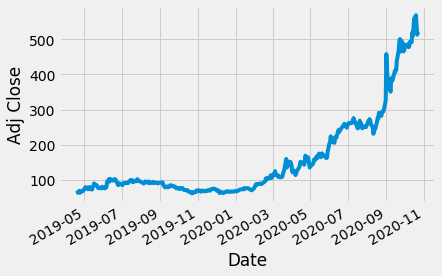

In [40]:
ZM['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.show()

Features Selection
We are going to run SVM calissifer on the following set of features  "𝑅𝑒𝑡−1,𝑅𝑒𝑡−2,𝑅𝑒𝑡5𝐷 , MOM 1D, MOM 5D, SMA 5D, EMA 7D, STD 21D, Volume" at time t-1, that are used to predict whether or not the stock’s price in the future will be higher (+1) or lower (-1) than the current day’s price, where:

In [41]:
price_ZM = np.round(ZM['Adj Close'],3)
Open_ZM = np.round(ZM['Open'],3)
High_ZM = np.round(ZM['High'],3)
Low_ZM = np.round(ZM['Low'],3)

# Calculating our returns for our stock QCOM  
rt_ZM=np.around([math.log(price_ZM[t]/price_ZM[t+1]) for t in range(0,len(price_ZM)-1)],3)
rt_ZM_t_2=np.around([math.log(price_ZM[t+1]/price_ZM[t+2]) for t in range(0,len(price_ZM)-2)],3)
rt_ZM_t_5=np.around([math.log(price_ZM[t+4]/price_ZM[t+5]) for t in range(0,len(price_ZM)-5)],3)

rt_5D_t_1=np.around([math.log(price_ZM[t]/price_ZM[t+5]) for t in range(0,len(price_ZM)-5)],3)
rt_10D_t_1=np.around([math.log(price_ZM[t]/price_ZM[t+10]) for t in range(0,len(price_ZM)-10)],3)

MOM1D=np.around([price_ZM[t]-price_ZM[t+1] for t in range(0,len(price_ZM)-1)],3)
MOM5D=np.around([price_ZM[t]-price_ZM[t+5] for t in range(5,len(price_ZM)-5)],3)
SMA5D=np.around(price_ZM.reindex(index=price_ZM.index[::-1]).rolling(5).mean(),3).tolist()
SMA5D.reverse()
EMA7D=np.around(price_ZM.reindex(index=price_ZM.index[::-1]).ewm(span=7).mean(),3).tolist()
EMA7D.reverse()
STD21D=np.around([np.std(rt_ZM[t:t+21]) for t in range(0,len(rt_ZM)-21)],3)

#### Step 2: Exploratory data analysis - Study summary statistics

Data preprocessing here involves firstly dividing the data into attributes and labels and then, dividing the data into training and testing sets.

A first goal is to construct a data frame that describes the main characteristics of ZM, our other stock under study from the 5-G universe

In [42]:
N=len(STD21D)
data_ZM={#'Date':ZM['Date'][:N],
'Returns 1D': rt_ZM[:N].tolist(),
'Returns 2D': rt_ZM_t_2[:N].tolist(),
'Returns 5D': rt_ZM_t_5[:N].tolist(),
'Returns 5D, t': rt_5D_t_1[:N].tolist(),
'Returns 10D, t': rt_10D_t_1[:N].tolist(),
'Open':Open_ZM[:N].tolist(),
'High':High_ZM[:N].tolist(),
'Low':Low_ZM[:N].tolist(),
'Mom 1D':MOM1D[:N].tolist(),
'Mom 5D':MOM5D[:N].tolist(),
'SMA 5D':SMA5D[:N],
'EMA 7D':EMA7D[:N],
'STD 21D':STD21D.tolist(),
'Volume': ZM['Volume'][:N]/1e6}        

In [43]:
X_ZM=pd.DataFrame(data_ZM)

X_ZM

,Returns 1D,Returns 2D,Returns 5D,"Returns 5D, t","Returns 10D, t",Open,High,Low,Mom 1D,Mom 5D,SMA 5D,EMA 7D,STD 21D,Volume
Date,,,,,,,,,,,,,,
2019-04-18,-0.058,-0.049,-0.019,-0.066,-0.245,65.000,66.000,60.321,-3.700,-12.96,64.980,66.318,0.053,25.7647
2019-04-22,-0.049,0.088,-0.029,-0.037,-0.175,61.000,68.900,59.940,-3.300,-10.07,65.824,67.757,0.052,9.9497
2019-04-23,0.088,-0.028,-0.061,-0.049,-0.061,66.870,74.169,65.550,5.800,-0.86,66.318,68.443,0.052,6.7865
2019-04-24,-0.028,-0.019,-0.004,-0.141,-0.206,71.400,71.500,63.160,-1.800,-4.92,67.012,68.257,0.049,4.9735
2019-04-25,-0.019,-0.029,-0.037,-0.150,-0.146,64.740,66.850,62.600,-1.220,0.29,68.924,69.943,0.050,3.8633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-16,-0.012,-0.060,-0.016,-0.204,-0.141,406.274,419.420,404.220,-4.955,30.42,444.219,444.646,0.036,6.7398
2020-09-17,-0.060,-0.066,0.074,-0.118,-0.156,389.000,417.820,387.000,-25.605,-18.01,462.691,456.812,0.037,9.2604
2020-09-18,-0.066,-0.050,-0.066,-0.124,-0.095,419.800,442.000,407.500,-29.740,14.27,473.062,471.385,0.035,22.3157


### Define Label
Here, the target variable is whether ZM's price will close up or down on the next trading day.

In [44]:
Y_ZM=pd.DataFrame({#'Date':ZM['Date'][:N],
    'Sign': np.sign(X_ZM['Returns 1D'])})

# To keep the continuity of time series, we can re-label 'no moves' as positive moves. We transform zeros 
# into ones which is more approriate as we remain on the binomial scheme. 
for i in range(len(Y_ZM['Sign'])):
    if Y_ZM['Sign'][i]==0:
        Y_ZM['Sign'][i]=1

# We check the output
Y_ZM

,Sign
Date,
2019-04-18,-1.0
2019-04-22,-1.0
2019-04-23,1.0
2019-04-24,-1.0
2019-04-25,-1.0
...,...
2020-09-16,-1.0
2020-09-17,-1.0
2020-09-18,-1.0


In [45]:
Y_ZM.shape  # Target Label should be 1D

(361, 1)

#### Step 3 Cleaning Dataset: The Data is already cleaned, no further imputation required.

#### Split Data


In [46]:
# Splitting the datasets into training and testing data.
X_ZMtrain, X_ZMtest, Y_ZMtrain, Y_ZMtest = train_test_split(X_ZM, Y_ZM, test_size=0.3, random_state=0, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_ZMtrain)}, {len(X_ZMtest)}")

Train and Test Size 252, 109


The training set contains 252 samples and the test set contains 109 samples.

#### Step 4 & 5 Transformation and Modelling:

#### Fit Model
We will now create, fit and train the SVM.

In [47]:
ZM_SVMpipe_hard=Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e5))]).fit(X_ZMtrain,Y_ZMtrain)
ZM_SVMpipe_soft=Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e-5))]).fit(X_ZMtrain,Y_ZMtrain)

#### Step 6 Metrics: Evaluating the model Classifier and Prediction Accuracy


In [48]:
# Predicting the test dataset
Y_ZM_pred_hard = ZM_SVMpipe_hard.predict(X_ZMtest)
Y_ZM_pred_hard[-5:]

array([-1., -1., -1., -1., -1.])

In [49]:
# Predicting the test dataset
Y_ZM_pred_soft = ZM_SVMpipe_soft.predict(X_ZMtest)
Y_ZM_pred_soft[-5:]

array([-1., -1., -1., -1.,  1.])

In [50]:
# Model Accuracy: how often is the classifier correct?
# Output prediction score
print(f'Train Accuracy: {ZM_SVMpipe_hard.score(X_ZMtrain,Y_ZMtrain):0.4}')
print(f'Test Accuracy: {ZM_SVMpipe_hard.score(X_ZMtest,Y_ZMtest):0.4}')

Train Accuracy: 1.0
Test Accuracy: 0.9541


In [51]:
print(f'Train Accuracy: {ZM_SVMpipe_soft.score(X_ZMtrain,Y_ZMtrain):0.4}')
print(f'Test Accuracy: {ZM_SVMpipe_soft.score(X_ZMtest,Y_ZMtest):0.4}')

Train Accuracy: 0.877
Test Accuracy: 0.8532


As in the QCOM case, SVM hard margin has better accuracy  than SVM soft margin.

#### Classification Report

For further evaluation, a classification report is used to measure the quality of predictions from a classification algorithm where we can also check precision, recall, f1_score and support of our model. Let's take a look at various performance metrics:

In [52]:
print(classification_report(Y_ZMtest, Y_ZM_pred_hard))

              precision    recall  f1-score   support

        -1.0       0.95      0.97      0.96        62
         1.0       0.96      0.94      0.95        47

    accuracy                           0.95       109
   macro avg       0.95      0.95      0.95       109
weighted avg       0.95      0.95      0.95       109



In [53]:
print(classification_report(Y_ZMtest, Y_ZM_pred_soft))

              precision    recall  f1-score   support

        -1.0       0.94      0.79      0.86        62
         1.0       0.77      0.94      0.85        47

    accuracy                           0.85       109
   macro avg       0.86      0.86      0.85       109
weighted avg       0.87      0.85      0.85       109



#### Investigate the prediction quality using area under ROC curve (each class) and confusion matrix 

We know that we have to consider the accuracy and pattern of prediction within each class. We use the tools of confusion matrix and area under the ROC curve to investigate.

#### Confusion Matrix:  Allows to look into accuracy of prediction within each class.

We plot below the confusion matrix of the exercise with our model classifiers: 

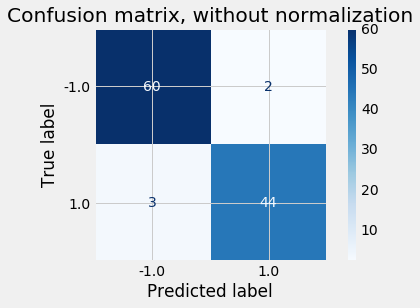

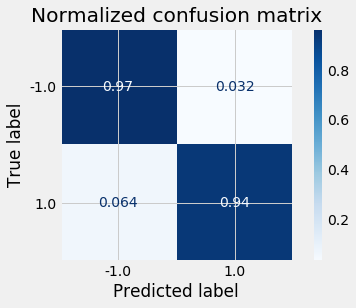

In [54]:
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(ZM_SVMpipe_hard, X_ZMtest, Y_ZMtest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

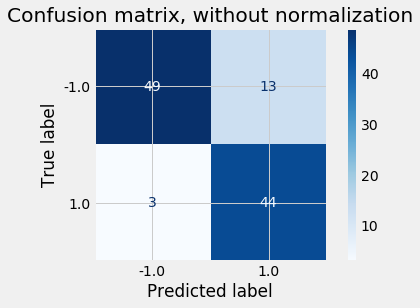

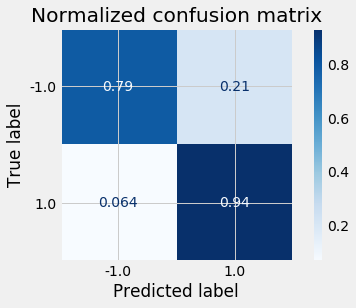

In [55]:
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(ZM_SVMpipe_soft, X_ZMtest, Y_ZMtest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

In the hard margin case, we observe that FP and FN in the normalized confusion matrix are almost 0.  

In the soft margin case, we observe that in this case, FP  throws a significant error of 20%. 

We can see that the SVM hard margin is more accurate than SVM soft margin.


#### Area under ROC Curve

Let's plot the ROC curve for ZM stock

In [56]:
ZM_SVMpipe_hard= CalibratedClassifierCV(Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e5))]).fit(X_ZMtrain,Y_ZMtrain)).fit(X_ZMtrain,Y_ZMtrain)
ZM_SVMpipe_hard_total=CalibratedClassifierCV(Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e5))]).fit(X_ZM,Y_ZM)).fit(X_ZM,Y_ZM)

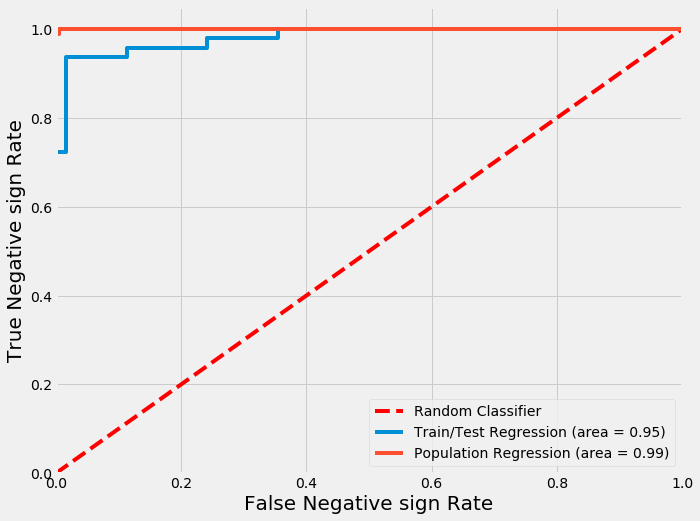

In [57]:
def plot_logistic_ROC(sign_ind):
	sign_name = ['Positive sign', 'Negative sign'] # This is in terms of label for Positives for Roc Curve
	logit_roc_aucT = roc_auc_score(Y_ZMtest, ZM_SVMpipe_hard.predict(X_ZMtest)) #Here, SVM_manual can run on Test or repeated on Train
	fprT, tprT, thresholdsT = roc_curve(Y_ZMtest, ZM_SVMpipe_hard.predict_proba(X_ZMtest)[:,1], pos_label=sign_ind)
	logit_roc_aucP = roc_auc_score(Y_ZM, ZM_SVMpipe_hard_total.predict(X_ZM))
	fprP, tprP, thresholdsP = roc_curve(Y_ZM, ZM_SVMpipe_hard_total.predict_proba(X_ZM)[:,1], pos_label=sign_ind)
	fig, ax = plt.subplots(figsize=(10,8))
	#fig = plt.figure(figsize=(18,10))
	# 1) Plot a diagnoal line of fully random classifier
	ax.plot([0, 1], [0, 1],'r--', label='Random Classifier')
	# 1) Plot ROC Curve for the precictions on Test Dataset
	ax.plot(fprT, tprT, label='Train/Test Regression (area = %0.2f)' % logit_roc_aucT)
	# 1) Plot ROC Curve for the Full Dataset (Population)
	ax.plot(fprP, tprP, label='Population Regression (area = %0.2f)' % logit_roc_aucP)
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False ' + sign_name[sign_ind] + ' Rate', fontsize=20)
	plt.ylabel('True ' + sign_name[sign_ind] + ' Rate', fontsize=20)
	plt.legend(loc="lower right", fontsize=14)
	plt.show()
	return ax
plot_logistic_ROC(1)

In [58]:
ZM_SVMpipe_soft=CalibratedClassifierCV(Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e-5))]).fit(X_ZMtrain,Y_ZMtrain)).fit(X_ZMtrain,Y_ZMtrain)
ZM_SVMpipe_soft_total=CalibratedClassifierCV(Pipeline([('scale', StandardScaler()),('SVC',LinearSVC(C=1e-5))]).fit(X_ZM,Y_ZM)).fit(X_ZM,Y_ZM)

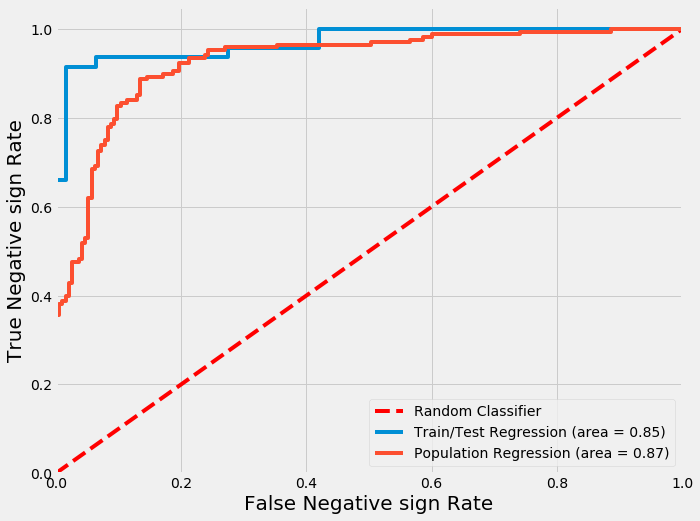

In [59]:
def plot_logistic_ROC(sign_ind):
	sign_name = ['Positive sign', 'Negative sign'] # This is in terms of label for Positives for Roc Curve
	logit_roc_aucT = roc_auc_score(Y_test, SVMpipe_soft.predict(X_test)) #Here, SVM_manual can run on Test or repeated on Train
	fprT, tprT, thresholdsT = roc_curve(Y_ZMtest, ZM_SVMpipe_soft.predict_proba(X_ZMtest)[:,1], pos_label=sign_ind)
	logit_roc_aucP = roc_auc_score(Y_ZM, ZM_SVMpipe_soft_total.predict(X_ZM))
	fprP, tprP, thresholdsP = roc_curve(Y_ZM, ZM_SVMpipe_soft_total.predict_proba(X_ZM)[:,1], pos_label=sign_ind)
	fig, ax = plt.subplots(figsize=(10,8))
	#fig = plt.figure(figsize=(18,10))
	# 1) Plot a diagnoal line of fully random classifier
	ax.plot([0, 1], [0, 1],'r--', label='Random Classifier')
	# 1) Plot ROC Curve for the precictions on Test Dataset
	ax.plot(fprT, tprT, label='Train/Test Regression (area = %0.2f)' % logit_roc_aucT)
	# 1) Plot ROC Curve for the Full Dataset (Population)
	ax.plot(fprP, tprP, label='Population Regression (area = %0.2f)' % logit_roc_aucP)
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False ' + sign_name[sign_ind] + ' Rate', fontsize=20)
	plt.ylabel('True ' + sign_name[sign_ind] + ' Rate', fontsize=20)
	plt.legend(loc="lower right", fontsize=14)
	plt.show()
	return ax
plot_logistic_ROC(1)

#### Cross-validation: Gridsearch to determine the value of C
We will perform a gridsearch to establish the optimal hyperparameter $C$ as in the QCom case

In [60]:
ZM_SVMpipe = Pipeline([('scale', StandardScaler()), ('SVC',LinearSVC())]) 
param_grid = {'SVC__C':np.arange(1e-5,1e5,100)}
ZM_SVMpipe = GridSearchCV(ZM_SVMpipe,param_grid,cv=5,return_train_score=True)
ZM_SVMpipe.fit(X_ZMtrain,Y_ZMtrain)
print(ZM_SVMpipe.best_params_)

{'SVC__C': 100.00001}


In [61]:
ZM_bestlinearSVC = ZM_SVMpipe.best_estimator_
ZM_bestlinearSVC.fit(X_ZMtrain,Y_ZMtrain)
ZM_bestlinearSVC.coef_ = bestlinearSVC.named_steps['SVC'].coef_
ZM_bestlinearSVC.score(X_ZMtrain,Y_ZMtrain)

0.996031746031746

We can observe that the optimal hyperparameter is $C=100$ 